In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandasql import sqldf
from sklearn.preprocessing import scale
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram , linkage, cut_tree
import squarify

In [2]:
pysqldf = lambda q: sqldf(q, globals())
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = (12,8)

# Data Wrangling

In [3]:
# we start with reading our dataset from the csv file
headers = ['customer_id', 'purchase_amount', 'date_of_purchase']
df = pd.read_csv('../Datasets/purchases.txt', header=None, 
                 names=headers, sep='\t')

In [4]:
df.head()

,customer_id,purchase_amount,date_of_purchase
0,760,25.00,2009-11-06
1,860,50.00,2012-09-28
2,1200,100.00,2005-10-25
3,1420,50.00,2009-07-09
4,1940,70.00,2013-01-25


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       51243 non-null  int64  
 1   purchase_amount   51243 non-null  float64
 2   date_of_purchase  51243 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [6]:
# Transform the last column to a date object
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'], 
                                        format='%Y-%m-%d')

In [7]:
# Extract year of purchase and save it as a column
df['year_of_purchase'] = df['date_of_purchase'].dt.year
# Add a day_since column showing the difference between last purchase and a basedate
basedate = pd.Timestamp('2016-01-01')
df['days_since'] = (basedate - df['date_of_purchase']).dt.days

In [8]:
# Display 5 randomly selected rows
df.sample(n=5, random_state=26)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase,days_since
1597,16730,40.00,2006-11-08,2006,3341
501,99890,20.00,2008-06-18,2008,2753
38205,165760,60.00,2011-11-25,2011,1498
6400,47500,15.00,2005-12-28,2005,3656
18334,9790,30.00,2012-03-03,2012,1399


In [9]:
# Summary statistics
df.describe()

,customer_id,purchase_amount,year_of_purchase,days_since
count,"51,243.00","51,243.00","51,243.00","51,243.00"
mean,"108,934.55",62.34,"2,010.87","1,631.94"
std,"67,650.61",156.61,2.88,"1,061.08"
min,10.00,5.00,"2,005.00",1.00
25%,"57,720.00",25.00,"2,009.00",733.00
50%,"102,440.00",30.00,"2,011.00","1,500.00"
75%,"160,525.00",60.00,"2,013.00","2,540.00"
max,"264,200.00","4,500.00","2,015.00","4,016.00"


# RFM Calculation

To implement the RFM analysis, further data processing need to be done.

Next we are going to compute the customers recency, frequency and average purchase amount. This part is a big tricky specially when it's done with pandas.

The trick here is that the customer ID will only appear once for every customer. So even though we have 51,000 purchases we'll only have as many unique customer IDs as there are in the database.

Now, for each customer, we need to compute the minimum number of days between all of his or her purchases and january 1st, 2016. Of course, if we take the minimum number of days, then we are going to have the day of the last purchase, which is the very definition of recency.

Then for each customer we need to compute the frequency, which is basically how many purchases that customer has made.

This is going to be done with the python sql module:

In [10]:
# Compute recency, frequency, and average purchase amount
q = """
        SELECT customer_id,
        MIN(days_since) AS 'recency',
        COUNT(*) AS 'frequency',
        AVG(purchase_amount) AS 'amount'
        FROM df GROUP BY 1"""
customers = sqldf(q)

The asterisk here basically means anything in the data that is related to that customer we could have put any known variable here, it wouldn't change and then for the amount we computed the average of purchase amount for that specific customer ID and name that aggregate computation as amount. 

Now, the trick is that we'd like to make sure that each row only appears one for each customer. So we going to compute that from the data and group by one, meaning that everything here is going to be computed and grouped per customer ID.

In [11]:
customers.head()

,customer_id,recency,frequency,amount
0,10,3829,1,30.00
1,80,343,7,71.43
2,90,758,10,115.80
3,120,1401,1,20.00
4,130,2970,2,50.00


# EDA

In [12]:
customers[['recency', 'frequency', 'amount']].describe()

,recency,frequency,amount
count,"18,417.00","18,417.00","18,417.00"
mean,"1,253.04",2.78,57.79
std,"1,081.44",2.94,154.36
min,1.00,1.00,5.00
25%,244.00,1.00,21.67
50%,"1,070.00",2.00,30.00
75%,"2,130.00",3.00,50.00
max,"4,014.00",45.00,"4,500.00"


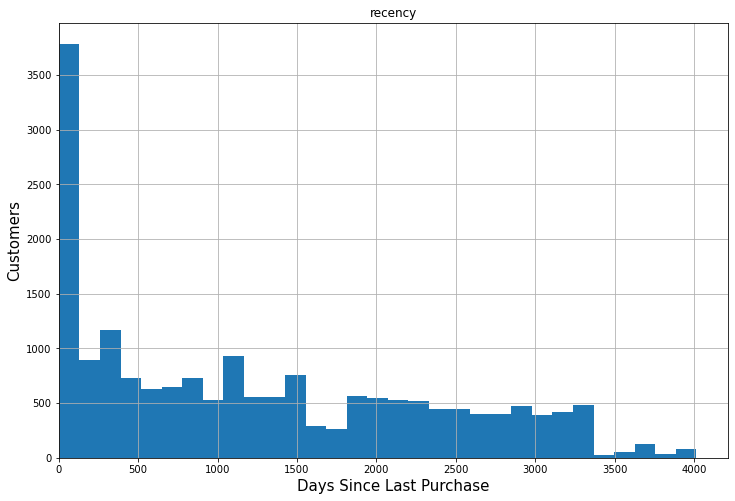

In [13]:
customers.hist(column='recency', bins=31)
plt.ylabel('Customers', fontsize=15)
plt.xlabel('Days Since Last Purchase', fontsize=15)
plt.xlim(0,);

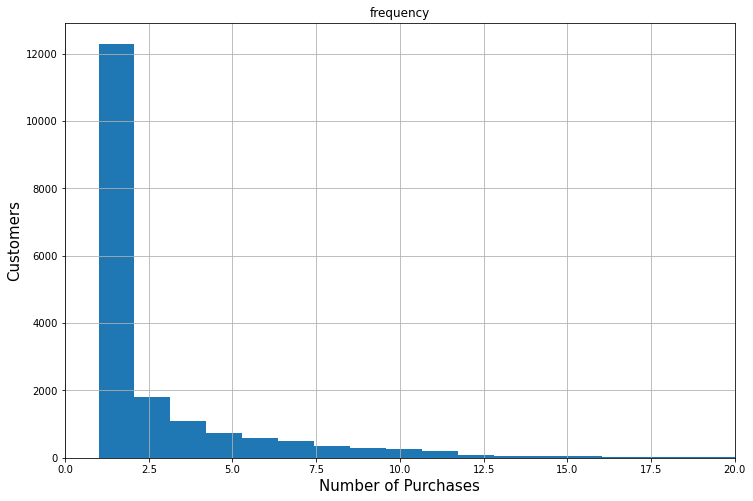

In [14]:
customers.hist(column='frequency', bins=41)
plt.ylabel('Customers', fontsize=15)
plt.xlabel('Number of Purchases', fontsize=15)
plt.xlim(0,20);

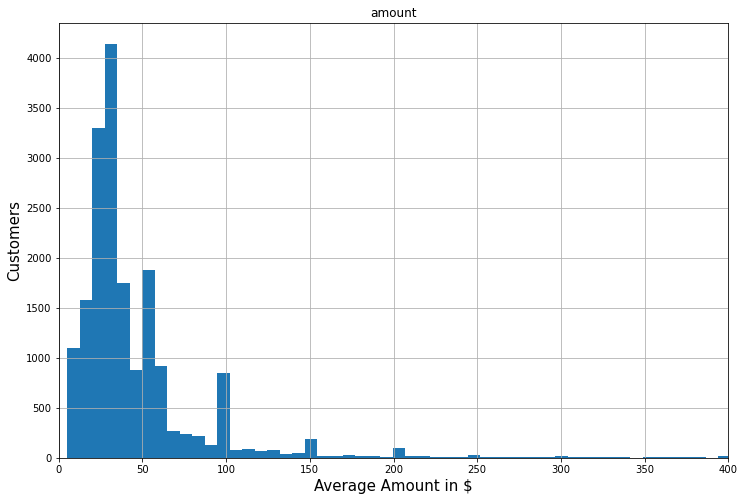

In [15]:
customers.hist(column='amount', bins=601)
plt.ylabel('Customers', fontsize=15)
plt.xlabel('Average Amount in $', fontsize=15)
plt.xlim(0,400)
plt.ylim(0,);

# HCA

## Data Transformation

In [16]:
# let's copy the data before starting the transformation
new_data = customers.copy()
new_data.set_index('customer_id', inplace=True)

Data transformation is an essantial part of segmentation. We need to prepare and transform our data, so the segmentation variables can be compared to one another.

Since our segmentation variables don't use the same scales, we have to standardize them. In statistical terms, to standardize means that we subtract the mean and divide by the standard deviation. Now, regardles of what the original scale was in days, dollar, or number of purchase, they can be compared to another.

Another issue to deal with is data dispersion or skewed data. Skew is the degree of distortion from a normal distribution. In the plot above we can see that the average amount of purchase in \\$ is right skewed, meaning there are a minority of very large values. When data is extremely skewed, it might be unuseful for segmentation purpose

When we are facing this kind of situation, it might be worth transforming the data into a logarithmic scale.

In [17]:
# Let's the log of the amount and plot again our data
new_data['amount'] = np.log10(new_data['amount'])

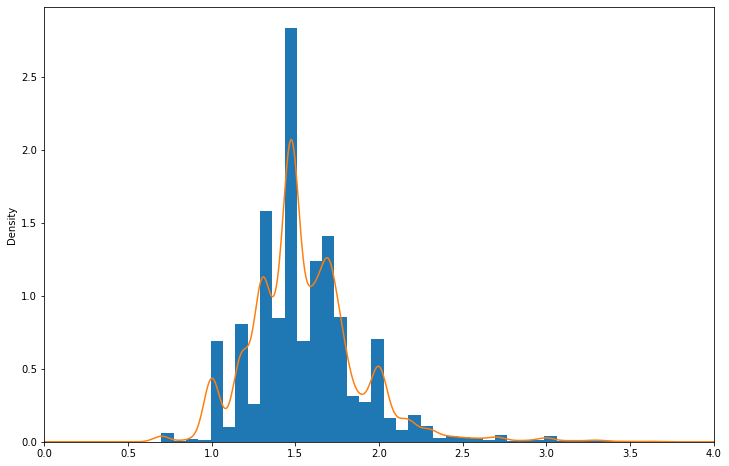

In [18]:
# plot
ax, fig = plt.subplots()
new_data['amount'].plot(kind='hist', density=True, bins=40)
new_data['amount'].plot(kind='kde')

plt.xlim(0,4)
plt.ylim(0,);

From the plot above we can see that after the transformation our data became more symmetrical and less skewed

In [19]:
# Now we scale our data and we save it as dataframe:
new_data = pd.DataFrame(scale(new_data), index=new_data.index, 
                        columns=new_data.columns)
# computing the distance would generate a huge matrix:
print(f'Dimension of the distance matrix: ({new_data.shape[0]**2}, {new_data.shape[1]})')

Dimension of the distance matrix: (339185889, 3)


In [20]:
# Since the distance matrix is that huge, 
# we are sampling with a sampling rate of 10\\%
sample = np.arange(0, 18417, 10)
sample[:10]

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

In [21]:
new_data_sample = new_data.iloc[sample]
new_data_sample.head()

,recency,frequency,amount
customer_id,,,
10,2.38,-0.61,-0.24
260,2.27,-0.61,-1.14
510,2.26,-0.61,-0.24
850,-1.14,2.46,-0.30
1040,-1.11,0.41,0.22


In [22]:
customers_sample = customers.iloc[sample].copy()
# we compute the distances on the sampled data
d = pdist(new_data_sample) # default metric is euclidean
# and we perform the hierarchical clustering:
hcward = linkage(d, method='ward')

## The Dendogram

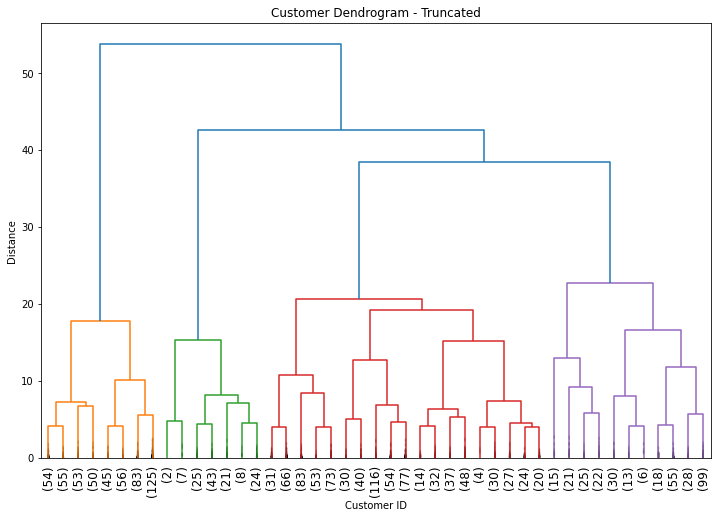

In [23]:
# Plot dendrogram
plt.title("Customer Dendrogram - Truncated")
dend = dendrogram(hcward, 
                  truncate_mode='lastp',
                  p = 45,
                  show_contracted=True,
                  leaf_rotation=90,
                  leaf_font_size=12);
plt.xlabel('Customer ID')
plt.ylabel('Distance');

## Determining the Number of Clusters

In RFM models it is usual to choose 11 clusters as recommended by [PULTER](https://bit.ly/32UPdhu) and other experts. They also provide a well-documented customer segment table with the description of each segment as well as a list of marketing actions corresponding to each segment. 

However, it doesn't have to be 11. When we start profiling we can tell if 11 was a good choice or not.

Remember: When it comes to cut-off selection there is no golden method on how to pick the perfect number of clusters. What matters is to use the right clustering approach for the business problem at hand and that your conclusions are actionable.

In [24]:
# Cut at 11 clusters
members = cut_tree(hcward, n_clusters=11)

## Capture the Clusters

In [25]:
# Assign to each customer a group
groups, counts = np.unique(members, return_counts=True)
segments = dict(zip(groups, counts))
customers_sample['group'] = members.flatten()
customers_sample.head()

,customer_id,recency,frequency,amount,group
0,10,3829,1,30.00,0
10,260,3710,1,15.00,1
20,510,3698,1,30.00,0
30,850,24,10,28.50,2
40,1040,56,4,42.50,3


In [26]:
# Create a table with the obtained groups and their characteristics
clusters = customers_sample[['recency', 'frequency', 'amount', 'group']].groupby('group').mean()
clusters

,recency,frequency,amount
group,,,
0,"2,563.24",1.28,37.78
1,"2,684.29",1.31,16.26
2,202.55,9.86,42.48
3,162.10,2.40,41.11
4,"2,567.04",1.86,214.86
5,448.58,6.58,261.22
6,"1,653.88",3.55,35.70
7,507.18,5.61,22.56
8,922.83,1.28,22.43


## Clusters Profiling

Now we have to do some cluster profiling.

In [27]:
clusters.sort_values(by=['amount', 'recency', 'frequency'], ascending=[False, True, False])

,recency,frequency,amount
group,,,
5,448.58,6.58,261.22
4,"2,567.04",1.86,214.86
10,799.34,1.40,87.43
2,202.55,9.86,42.48
3,162.10,2.40,41.11
0,"2,563.24",1.28,37.78
9,74.00,20.78,35.80
6,"1,653.88",3.55,35.70
7,507.18,5.61,22.56


11 Segments is not optimal in this case, we have some overlapping segments. So let's try 8 clusters and see if it does better.

In [28]:
# Cut at 6 clusters
members = cut_tree(hcward, n_clusters=6)
# Assign to each customer a group
groups, counts = np.unique(members, return_counts=True)
segments = dict(zip(groups, counts))
customers_sample['group'] = members.flatten()
# Create a table with the obtained groups and their characteristics
clusters = customers_sample[['recency', 'frequency', 'amount', 'group']].groupby('group').mean()
clusters

,recency,frequency,amount
group,,,
0,"2,612.50",1.30,29.03
1,193.65,10.62,42.02
2,162.10,2.40,41.11
3,"1,147.20",1.49,112.51
4,448.58,6.58,261.22
5,"1,017.09",2.64,25.60


Result of the profiling:

1. cluster 0 = lost
2. cluster 1 = loyal customers
3. cluster 2 = promising
4. cluster 3 = Can't lose them
5. cluster 4 = champions
6. cluster 5 = about to sleep

In [29]:
clusters['n_customers'] = customers_sample['group'].value_counts()
clusters['cluster_names'] = ['lost', 'loyal', 'promising', 
                 "can't lose them", 'champions', 'about to sleep']


In [30]:
clusters

,recency,frequency,amount,n_customers,cluster_names
group,,,,,
0,"2,612.50",1.30,29.03,521,lost
1,193.65,10.62,42.02,130,loyal
2,162.10,2.40,41.11,306,promising
3,"1,147.20",1.49,112.51,249,can't lose them
4,448.58,6.58,261.22,83,champions
5,"1,017.09",2.64,25.60,553,about to sleep


## Visualization

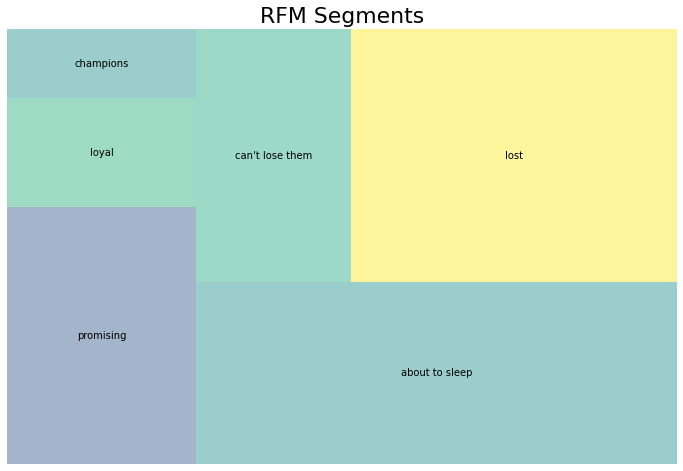

In [32]:
clusters.sort_values(by=['recency', 'amount'], ascending=[True, False], inplace=True)

squarify.plot(sizes=clusters['n_customers'], 
              label=clusters['cluster_names'], alpha=.45 )
plt.title("RFM Segments",fontsize=22)
plt.axis('off');